<p style="padding-top: 3cm;"></p>

<h1 style=font-size:40px; align="center">Multiscale IoU (MIoU)</h1> 
<h3 style=font-size:30px; align="center">A Metric for Evaluation of Salient Object Detection with Fine Structures</h3>
<h4 style=font-size:18px; align="center"><i>Azim Ahmadzadeh, Dustin J. Kempton, Yang Chen, Rafal A. Angryk</i></h4>
<h5 style=font-size:14px; align="center">Submitted to <a href="https://2021.ieeeicip.org/">ICIP 2021</a>. (under review)</h5>

<p style="padding-bottom: 2cm;"></p>
<hr />

<!--- for using MathJax --->
<script src="https://polyfill.io/v3/polyfill.min.js?features=es6"></script>
<script id="MathJax-script" async src="https://cdn.jsdelivr.net/npm/mathjax@3/es5/tex-mml-chtml.js"></script>

<p style=font-size:18px;>
    <b>Note:</b> This notebook is provided as supplementary material. Please see the paper for details.
<p>

In [1]:
# external imports
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from PIL import Image
from scipy.stats import linregress
from scipy import ndimage
# internal imports
from miou.metrics.precision_recall import PrecisionRecall
from miou.metrics.iou import IoU
from miou.metrics.miou import MIoU
from miou.utils import mask_loader
%matplotlib inline

<h3 style=font-size:30px;><font color="Grey">Examples</font></h3>

<p style=font-size:18px;>
    In the following, we present examples from different domains showing that the metrics <i>IoU</i>, <i>Precision</i>, <i>Recall</i>, and <i>F1-score</i> fail to capture prominent differences between the proposed regions, $dt_1$ and $dt_2$, when compared with the ground-truth region, $gt$.
</p>

---

<h3 style=font-size:24px;><i class="fas fa-flask"></i><font color="Grey"> Example A:</font> A Simple Case</h3>
<p style=font-size:18px;>
The graphic below depics shows a ground-truth region and two very different proposed regions. Note that (1) $dt_1$ and $dt_2$ have equal areas, but (2) only $dt_2$ has the jagged boundary structure of the ground-truth region.
</p>

<img src="../test_images/Exp-B_Fig1-A.png" align='center' style="width: 500px;">

In [2]:
mask1 = mask_loader.load_mask('../test_images/test_segm_input_B/mask1.png')
mask2 = mask_loader.load_mask('../test_images/test_segm_input_B/mask2.png')
mask3 = mask_loader.load_mask('../test_images/test_segm_input_B/mask3.png')
masks = [mask1, mask2, mask3]

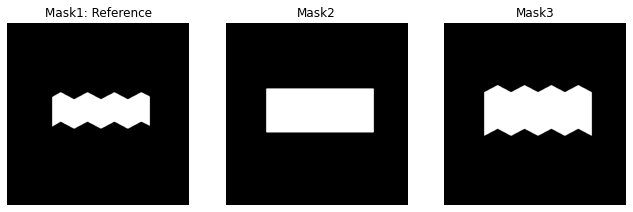

In [3]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [5]:
boxsizes = np.power(2, np.linspace(0, 9, num=10, dtype=int))
ious, f1s, pres, recs, ratios, areas = [], [], [], [], [], []
iou = IoU(edge_only=False)
pr = PrecisionRecall(edge_only=False)

for m in masks:
    # ----- IoU -----------------
    ious.append(iou.measure(mask1, m))
    # ----- F1 Score -------------
    pr.measure(mask1, m)
    f1s.append(pr.fscore)
    pres.append(pr.pr['precision'])
    recs.append(pr.pr['recall']) 
    # ----- MIoU -----------------
    miou = MIoU(boxsizes, edge_only=True)
    areas.append(miou.measure(mask1, m))
    ratios.append(miou.ratios)
    
measures_list=[f1s, pres, recs, ious, areas]

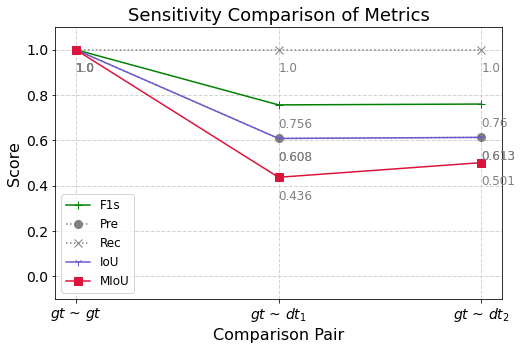

In [6]:
x = np.arange(1, len(measures_list[0]) + 1, dtype=int)
y_max = max([max(measures) for measures in measures_list])
plots = []
colors = ['green', 'gray', 'gray', 'slateblue', 'crimson']
legend_labels = ['F1s', 'Pre', 'Rec', 'IoU', 'MIoU']
labels = ['$gt$ ~ $gt$', '$gt$ ~ $dt_1$', '$gt$ ~ $dt_2$']
markers = ['+', 'o', 'x', '1', 's']
linestyles = ['solid', 'dotted', 'dotted', 'solid', 'solid']
fig, ax = plt.subplots(figsize=(8, 5))
for i, measures in enumerate(measures_list):
    plots.append(plt.plot(x, measures,
                          color=colors[i], linestyle=linestyles[i], linewidth=1.5,
                          marker=markers[i], markersize=8,  label=legend_labels[i]))
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.ylim(-0.1, y_max + 0.1)
plt.title('Sensitivity Comparison of Metrics', fontsize=18)
plt.xlabel('Comparison Pair', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=1)
for measures in measures_list:
    for i in np.arange(len(measures)):
        ax.annotate(np.round(measures[i], 3), (x[i], np.abs(measures[i] - 0.1)),
                    fontsize=12, color='gray')
plt.legend(legend_labels,fontsize=12)
plt.show()

---
<h3 style=font-size:24px;><i class="fas fa-flask"></i><font color="Grey"> Example B:</font> A Solar Filament</h3>
<p style=font-size:18px;>
    This example shows <a href="http://ftp.bbso.njit.edu/pub/archive/2012/02/21/">a filament</a> (captured by the <a href="http://www.bbso.njit.edu/">Big Bear Solar Observatory</a> at <code>2012-02-21 19:12:50 (UTC)</code>) and two
proposed regions; one with the barbs ($dt_1$) and the other without any ($dt_2$). If one were to evaluate the proposed regions with any of
the previously listed metrics, as the results show, only our proposed <i>MIoU</i> would provide a preference towards the example with barbs over the example with none.
</p>

<img src="../test_images/Exp-Z2_Fig1-B.png" align='center' style="width: 500px;">

In [7]:
mask1 = mask_loader.load_mask('../test_images/test_segm_input_Z2/mask1.png')
mask2 = mask_loader.load_mask('../test_images/test_segm_input_Z2/mask2.png')
mask3 = mask_loader.load_mask('../test_images/test_segm_input_Z2/mask3.png')
masks = [mask1, mask2, mask3]

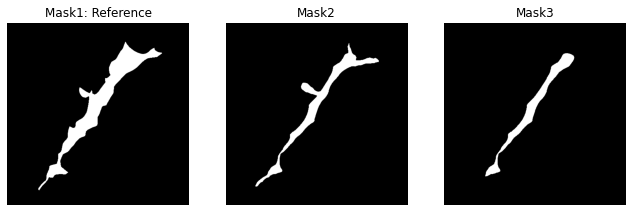

In [8]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [9]:
boxsizes = np.power(2, np.linspace(0, 9, num=10, dtype=int))
ious, f1s, pres, recs, ratios, areas = [], [], [], [], [], []
iou = IoU(edge_only=False)
pr = PrecisionRecall(edge_only=False)

for m in masks:
    # ----- IoU -----------------
    ious.append(iou.measure(mask1, m))
    # ----- F1 Score -------------
    pr.measure(mask1, m)
    f1s.append(pr.fscore)
    pres.append(pr.pr['precision'])
    recs.append(pr.pr['recall']) 
    # ----- MIoU -----------------
    miou = MIoU(boxsizes, edge_only=True)
    areas.append(miou.measure(mask1, m))
    ratios.append(miou.ratios)
    
measures_list=[f1s, pres, recs, ious, areas]

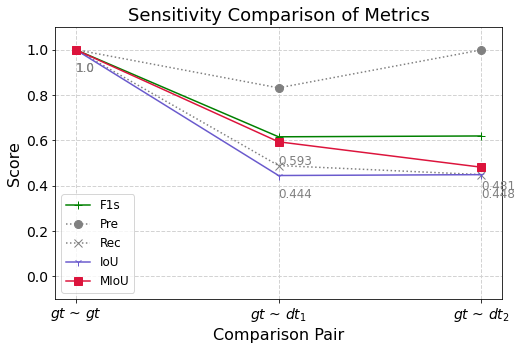

In [10]:
x = np.arange(1, len(measures_list[0]) + 1, dtype=int)
y_max = max([max(measures) for measures in measures_list])
plots = []
colors = ['green', 'gray', 'gray', 'slateblue', 'crimson']
legend_labels = ['F1s', 'Pre', 'Rec', 'IoU', 'MIoU']
labels = ['$gt$ ~ $gt$', '$gt$ ~ $dt_1$', '$gt$ ~ $dt_2$']
markers = ['+', 'o', 'x', '1', 's']
linestyles = ['solid', 'dotted', 'dotted', 'solid', 'solid']
fig, ax = plt.subplots(figsize=(8, 5))
for i, measures in enumerate(measures_list):
    plots.append(plt.plot(x, measures,
                          color=colors[i], linestyle=linestyles[i], linewidth=1.5,
                          marker=markers[i], markersize=8,  label=legend_labels[i]))
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.ylim(-0.1, y_max + 0.1)
plt.title('Sensitivity Comparison of Metrics', fontsize=18)
plt.xlabel('Comparison Pair', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=1)

for i, metric in enumerate(legend_labels):
    if metric.endswith('IoU'):
        measures = measures_list[i]
        for j in np.arange(len(measures)):
            ax.annotate(np.round(measures[j], 3), (x[j], np.abs(measures[j] - 0.1)),
                    fontsize=12, color='gray')

plt.legend(legend_labels, fontsize=12)
plt.show()

---
<h3 style=font-size:24px;><i class="fas fa-flask"></i><font color="Grey"> Example C:</font> A Leaf Sample</h3>
<p style=font-size:18px;>
    This example shows a leaf’s shape, $gt$, (from <a href="https://neerajkumar.org/projects/leafsnap/">LeafSnap</a> dataset, with ID <code>ny1041-04-1</code>), and two proposed shapes, $dt_1$ and $dt_2$. As the results show, none of the listed metrics (except MIoU) differentiate between $dt_1$ and $dt_2$ , and they fail to see the similarity that $dt_1$ exhibits to the ground-truth region, relative to $dt_2$.
</p>

<img src="../test_images/Exp-Z3_Fig1-C.png" align='center' style="width: 500px;">

In [11]:
mask1 = mask_loader.load_mask('../test_images/test_segm_input_Z3/mask1.png')
mask2 = mask_loader.load_mask('../test_images/test_segm_input_Z3/mask2.png')
mask3 = mask_loader.load_mask('../test_images/test_segm_input_Z3/mask3.png')
masks = [mask1, mask2, mask3]

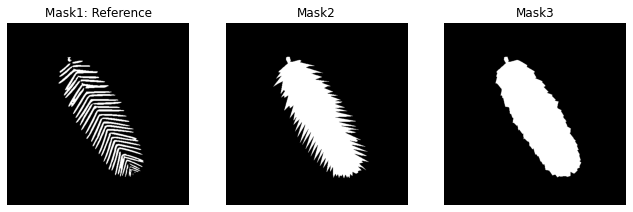

In [12]:
fig = plt.figure(figsize=(15, len(masks) * 15))
all_axes = []
j = 0
for i in range(len(masks)):
    all_axes.append(fig.add_subplot(1,4,i+1))

for ax in all_axes:
    ax.axis('off')
    title = 'Mask{}'.format(j+1) if j!=0 else 'Mask{}: Reference'.format(j+1)
    ax.set_title(title)
    ax.imshow(masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [13]:
boxsizes = np.power(2, np.linspace(0, 9, num=10, dtype=int))
ious, f1s, pres, recs, ratios, areas = [], [], [], [], [], []
iou = IoU(edge_only=False)
pr = PrecisionRecall(edge_only=False)

for m in masks:
    # ----- IoU -----------------
    ious.append(iou.measure(mask1, m))
    # ----- F1 Score -------------
    pr.measure(mask1, m)
    f1s.append(pr.fscore)
    pres.append(pr.pr['precision'])
    recs.append(pr.pr['recall']) 
    # ----- MIoU -----------------
    miou = MIoU(boxsizes, edge_only=True)
    areas.append(miou.measure(mask1, m))
    ratios.append(miou.ratios)
    
measures_list=[f1s, pres, recs, ious, areas]

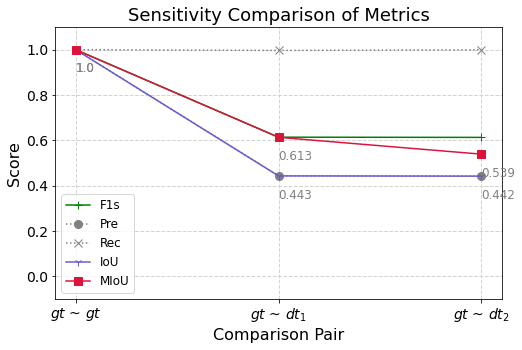

In [15]:
x = np.arange(1, len(measures_list[0]) + 1, dtype=int)
y_max = max([max(measures) for measures in measures_list])
plots = []
colors = ['green', 'gray', 'gray', 'slateblue', 'crimson']
legend_labels = ['F1s', 'Pre', 'Rec', 'IoU', 'MIoU']
labels = ['$gt$ ~ $gt$', '$gt$ ~ $dt_1$', '$gt$ ~ $dt_2$']
markers = ['+', 'o', 'x', '1', 's']
linestyles = ['solid', 'dotted', 'dotted', 'solid', 'solid']
fig, ax = plt.subplots(figsize=(8, 5))
for i, measures in enumerate(measures_list):
    plots.append(plt.plot(x, measures,
                          color=colors[i], linestyle=linestyles[i], linewidth=1.5,
                          marker=markers[i], markersize=8,  label=legend_labels[i]))
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.ylim(-0.1, y_max + 0.1)
plt.title('Sensitivity Comparison of Metrics', fontsize=18)
plt.xlabel('Comparison Pair', fontsize=16)
plt.ylabel('Score', fontsize=16)
plt.grid(color='lightgray', linestyle='--', linewidth=1)

for i, metric in enumerate(legend_labels):
    if metric.endswith('IoU'):
        measures = measures_list[i]
        for j in np.arange(len(measures)):
            ax.annotate(np.round(measures[j], 3), (x[j], np.abs(measures[j] - 0.1)),
                    fontsize=12, color='gray')
            
plt.legend(legend_labels, fontsize=12)
plt.show()

---
<h3 style=font-size:24px;><i class="fas fa-flask"></i><font color="Grey"> Example D:</font> On Synthetic Regions</h3>
<p style=font-size:18px;>
    This example shows a palette of proposed regions for one ground-truth region, i.e., <code>mask 3-1</code>. The proposed regions are generated by a systematic deviation from the ground-truth region, by means of linear scaling (mid-to-tail rows),  translation (mid-to-head rows), and smoothing (left to right). The goal is to examine the sensitivity of <i>IoU</i> and <i>MIoU</i> to the jagged patterns, in the presence of different transformations. Comparing each of these regions with the ground-truth region, the measured similarity is expected to decrease from left to right, as the proposed regions lose their jagged structure. Following this expectation, a metric that is sensitive to the boundary structure of regions must show a periodically decreasing pattern, peaking at the beginning of each row.
</p>

<img src="../test_images/Exp-F_Fig2.png" align='center' style="width: 400px;">

In [16]:
path = '../test_images/test_segm_input_F/'

all_paths = [os.path.join(path, f) for f in os.listdir(path) if f.startswith('mask')]
all_paths.sort(key=lambda f: int(''.join(filter(str.isdigit, f))))

all_masks = []
for p in all_paths:
    all_masks.append(mask_loader.load_mask(p))

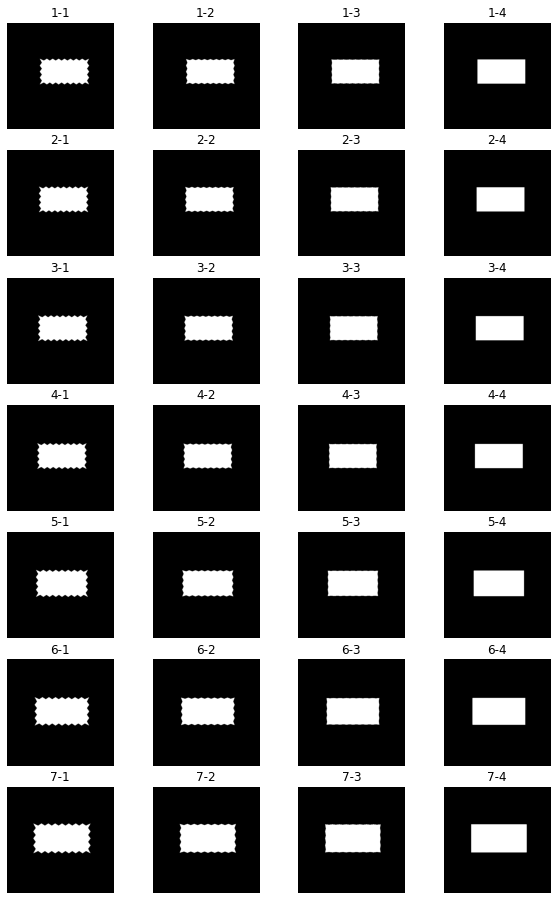

In [17]:
n_rows, n_cols = 7, 4
fig = plt.figure(figsize=(10, 16))
all_axes = []
j = 0
for i in range(len(all_paths)):
    all_axes.append(fig.add_subplot(n_rows, n_cols, i+1))

labels = []
for ax in all_axes:
    ax.axis('off')
    title = '{}-{}'.format(all_paths[j][-7], all_paths[j][-5])
    labels.append(title)
    ax.set_title(title, fontsize= 12)
    ax.imshow(all_masks[j], cmap='gist_gray')
    j = j + 1

plt.show()

In [18]:
boxsizes = np.power(2, np.linspace(0, 9, num=10, dtype=int))

ref_idx = 12   # index of reference object (i.e. ground truth)
gt = all_masks[ref_idx]
ious, areas, f1s, pres, recs = [], [], [], [], []

pr = PrecisionRecall(edge_only=False)
iou = IoU(edge_only=False)

for m in all_masks:
    # --- F1-score ---------------
    pr.measure(gt, m)
    f1s.append(pr.fscore)
    pres.append(pr.pr['precision'])
    recs.append(pr.pr['recall']) 
    # --- IoU --------------------
    ious.append(iou.measure(gt, m))
    # --- MIoU -------------------
    miou = MIoU(boxsizes, edge_only=True)
    areas.append(miou.measure(gt, m))

measures_list=[f1s, pres, recs, ious, areas]

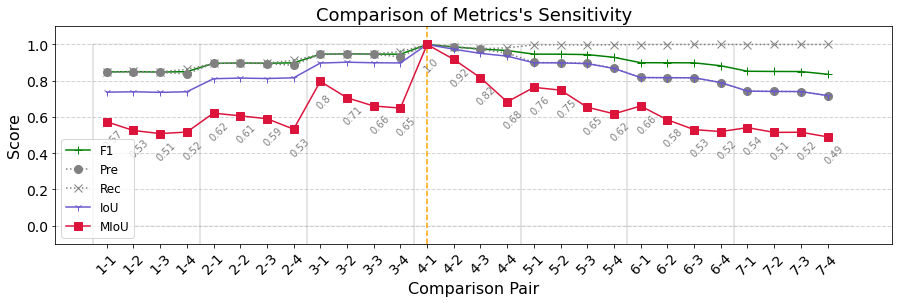

In [19]:
x = np.arange(0, len(all_masks), dtype=int)
areas_c = list(1 - np.array(areas))
areas_c = areas
plots = []
colors = ['green', 'gray', 'gray', 'slateblue', 'crimson']
legend_labels = ['F1', 'Pre', 'Rec', 'IoU', 'MIoU']
labels = ['{}-{}'.format(i,j) for i in range(1, n_rows+1) for j in range(1,n_cols+1)]
markers = ['+', 'o', 'x', '1', 's']
linestyles = ['solid', 'dotted', 'dotted', 'solid', 'solid']

ymin = -0.1
ymax = max([max(measures) for measures in measures_list])

fig, ax = plt.subplots(figsize=(15, 4))
for i, measures in enumerate(measures_list):
    plots.append(plt.plot(x, measures,
                          color=colors[i], linestyle=linestyles[i], linewidth=1.5,
                          marker=markers[i], markersize=8,  label=legend_labels[i]))    

ax.set_xticks(x)
ax.set_xticklabels(labels, rotation=45, fontsize=14)
ax.yaxis.set_tick_params(labelsize=14)
plt.grid(axis='y', which='both', color='lightgray', linestyle='--', linewidth=1)
plt.ylim(ymin, ymax + 0.1)
plt.vlines(ref_idx, ymin=ymin, ymax=ymax + 0.1, colors='orange', linestyles='--', label='GT')
plt.vlines(x[::4]-0.5, ymin=ymin, ymax=ymax, colors='gray', linestyles='solid', lw=0.4)
plt.hlines(y=0.0, xmin=-0.5, xmax=len(all_masks), colors='gray', linestyles=':', lw=0.4)
plt.hlines(y=1.0, xmin=-0.5, xmax=len(all_masks), colors='gray', linestyles=':', lw=0.4)
plt.title("Comparison of Metrics's Sensitivity", fontsize=18)
plt.xlabel('Comparison Pair', fontsize=16)
plt.ylabel('Score', fontsize=16)


for i in np.arange(len(all_masks)):
    ax.annotate(np.round(areas_c[i], 2), (x[i]-0.2, areas_c[i] - 0.15), color='gray', rotation=45)

plt.legend(legend_labels, fontsize=12)
plt.show()

<p style=font-size:18px;>
    As the line plot shows, although all other metrics capture the between-row differences (periodically plateaued), only <i>MIoU</i> is sensitive enough to reflect the within-row differences, hence the periodically decreasing pattern.
</p>

---
<h3 style=font-size:24px;><i class="fas fa-flask"></i><font color="Grey"> Example E:</font> On Real Regions</h3>
<p style=font-size:18px;>
    Below, instances of five categories from the <a href="https://cocodataset.org/">COCO dataset</a> are shown. To compare the distribution of <i>MIoU</i> with that of <i>IoU</i> on real objects, we randomly sample a total of 2500 instances, equally collected from five categories (cars, bicycles, boats, dogs, and persons). We then apply some minimal manipulations to the ground-truth regions to generate two groups of proposed regions: The <b>first group</b> contains copies of the ground-truth regions which are randomly rotated (±10 deg.) and/or translated (±10 px.). The <b>second group</b> is made of the smoothened duplicates of the ground-truth regions, using Gaussian smoothing followed by
thresholding to obtain binary masks.
</p>

<img src="../test_images/coco_categories.png" align='center' style="width: 400px;">

In [20]:
# category list
cate_list = ['person', 'bicycle', 'car', 'dog', 'boat']

# load evaluation results, including IoU and MIoU, from npy files.
evl_rs_dir = '../test_images/test_segm_input_X/npy_files/'
iou_results, miou_results = [], []
for i in cate_list:
    evl_rs_tmp = np.load(evl_rs_dir + i + '_evl_results.npy')
    iou_results.append(evl_rs_tmp[:, 0])
    miou_results.append(evl_rs_tmp[:, 1])

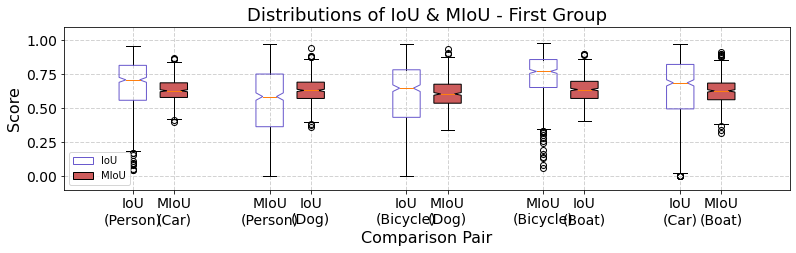

In [22]:
fig, ax = plt.subplots(figsize=(13, 3))
b1_widths = [0.2, 0.2, 0.2, 0.2, 0.2]
b2_widths = [0.2, 0.2, 0.2, 0.2, 0.2]
b1_positions = [0, 1.0, 2.0, 3.0, 4.0]
b2_positions = [0.3, 1.3, 2.3, 3.3, 4.3]
legend_labels = ['IoU', 'MIoU']
# colors = ['lightsteelblue', 'cornflowerblue']
colors = ['slateblue', 'indianred', 'black']
labels = ['Person', 'Bicycle', 'Car', 'Dog', 'Boat']
b1plot = ax.boxplot(iou_results, positions=b1_positions, widths=b1_widths,
                    patch_artist=True, notch=True, #labels=labels,
                    boxprops=dict(facecolor=(0,0,0,0), edgecolor=colors[0]))

b2plot = ax.boxplot(miou_results, positions=b2_positions, widths=b2_widths,
                    patch_artist=True, notch=True, #labels=labels,
                    boxprops=dict(facecolor=colors[1], edgecolor=colors[2])) 

ax.set_xticklabels(['IoU\n(Person)', 'MIoU\n(Person)', 'IoU\n(Bicycle)', 'MIoU\n(Bicycle)', 
                    'IoU\n(Car)', 'MIoU\n(Car)', 'IoU\n(Dog)', 'MIoU\n(Dog)', 'IoU\n(Boat)',
                    'MIoU\n(Boat)'],
                   fontsize=14)

plt.ylim(-0.1, 1.1)
plt.grid(color='lightgray', linestyle='--', linewidth=1)
plt.title("Distributions of IoU & MIoU - First Group", fontsize=18)
plt.xlabel("Comparison Pair", fontsize=16)
plt.ylabel("Score", fontsize=16) 
ax.yaxis.set_tick_params(labelsize=14)

ax.legend([b1plot["boxes"][0], b2plot["boxes"][0]], legend_labels, loc="lower left")
plt.show()

In [23]:
cate_list = ['person', 'bicycle', 'car', 'dog', 'boat']

# load evaluation results, including IoU and MIoU, from npy files.
evl_rs_dir = '../test_images/test_segm_input_X/npy_files/'
iou_results, miou_results = [], []
for i in cate_list:
    evl_rs_tmp = np.load(evl_rs_dir + i + '_evl_results_gaussian.npy')
    iou_results.append(evl_rs_tmp[:, 0])
    miou_results.append(evl_rs_tmp[:, 1])

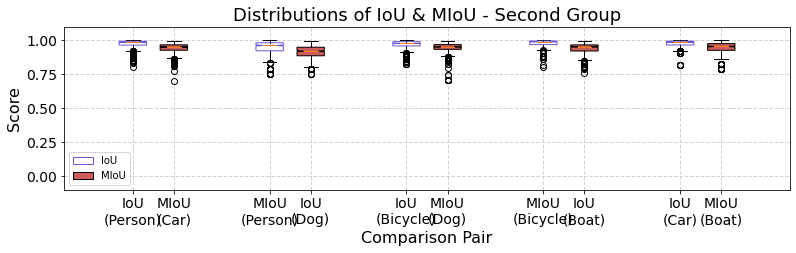

In [24]:
fig, ax = plt.subplots(figsize=(13, 3))

b1_widths = [0.2, 0.2, 0.2, 0.2, 0.2]
b2_widths = [0.2, 0.2, 0.2, 0.2, 0.2]
b1_positions = [0, 1.0, 2.0, 3.0, 4.0]
b2_positions = [0.3, 1.3, 2.3, 3.3, 4.3]
legend_labels = ['IoU', 'MIoU']
colors = ['slateblue', 'indianred', 'black']
labels = ['Person', 'Bicycle', 'Car', 'Dog', 'Boat']
b1plot = ax.boxplot(iou_results, positions=b1_positions, widths=b1_widths,
                    patch_artist=True, notch=True, #labels=labels,
                    boxprops=dict(facecolor=(0,0,0,0), edgecolor=colors[0]))

b2plot = ax.boxplot(miou_results, positions=b2_positions, widths=b2_widths,
                    patch_artist=True, notch=True, #labels=labels,
                    boxprops=dict(facecolor=colors[1], edgecolor=colors[2])) 

ax.set_xticklabels(['IoU\n(Person)', 'MIoU\n(Person)', 'IoU\n(Bicycle)', 'MIoU\n(Bicycle)', 
                    'IoU\n(Car)', 'MIoU\n(Car)', 'IoU\n(Dog)', 'MIoU\n(Dog)', 'IoU\n(Boat)',
                    'MIoU\n(Boat)'],
                   fontsize=14) # rotation=45, 

plt.ylim(-0.1, 1.1)
plt.grid(color='lightgray', linestyle='--', linewidth=1)
plt.title("Distributions of IoU & MIoU - Second Group", fontsize=18)
plt.xlabel("Comparison Pair", fontsize=16)
plt.ylabel("Score", fontsize=16) 
ax.yaxis.set_tick_params(labelsize=14)

ax.legend([b1plot["boxes"][0], b2plot["boxes"][0]], legend_labels, loc="lower left")
plt.show()

<p style=font-size:18px;>
    As the results show, overall, despite the fundamental differences between the two metrics’ definitions, their distributions are similar. This indicates that <i>MIoU</i> is a reliable alternative for <i>IoU</i>.
</p>

<p style=font-size:18px;>
    Moreover, in the first group's box plots, <i>MIoU</i>’s distributions are centered at the median, across categories, with a significantly smaller variance than that of <i>IoU</i>. This is, we believe, the result of <i>MIoU</i>’s intended sensitivity to the regions’ boundary structure, rather than just the area of intersection.
</p>
<p style=font-size:18px;>
    The pairs of distributions in the second groups's boxplots are also very similar while <i>MIoU</i>’s median remains slightly below IoU’s across all five categories. This consistent difference confirms the sensitivity of <i>MIoU</i> to the details that were smoothened out in this experiment.
</p>